The analysis has been performed using 365 days of complaints data till the day 11/16/2017. I have used python libraries for the analysis. Additionaly I have also used Arcmap for performing spatial joins (Can be done using PostGIS too, but I didnt find the need to create a database for the current analysis). 

I performed hotspot-coldspot analysis to identify neighborhoods with high instances of complaints. I have used census tract geographies instead of zipcodes for this analysis as census tracts are a more accurate representation of a geography.

In [31]:
import csv
import numpy as np
import pandas as pd
import geopandas as gp
import matplotlib.pylab as plt
from datetime import datetime
import pysal as ps
from shapely.geometry import Point
from matplotlib import colors
%matplotlib inline

### Loading 311 hotline data for complaints refered to the Housing Preservation and Development Agency (HPD). I have only used one year's data (365 days)

In [221]:
df = pd.read_csv('cleanHPDWithAddress.csv')
df.head()

,Unnamed: 0,Unique Key,Agency,Borough,Created Date,Closed Date,Community Board,Complaint Type,Descriptor,Latitude,Longitude,Incident Zip,Incident Address,Status,Resolution Action Updated Date,Resolution Description
0,0,35849868,HPD,BRONX,03/31/2017 04:59:16 PM,04/04/2017 04:30:20 PM,04 BRONX,HEAT/HOT WATER,APARTMENT ONLY,40.833716,-73.914883,10456.0,1212 GRANT AVENUE,Closed,04/04/2017 04:30:20 PM,The Department of Housing Preservation and Dev...
1,1,37641999,HPD,BROOKLYN,11/08/2017 01:14:42 PM,NaN,03 BROOKLYN,ELECTRIC,LIGHTING,40.684900,-73.948937,11216.0,246 MADISON STREET,Open,11/08/2017 12:00:00 AM,The following complaint conditions are still o...
2,2,36711082,HPD,MANHATTAN,07/16/2017 05:32:12 PM,07/18/2017 02:00:11 PM,10 MANHATTAN,GENERAL,COOKING GAS,40.805972,-73.953027,10026.0,271 WEST 119 STREET,Closed,07/18/2017 02:00:11 PM,The complaint you filed is a duplicate of a co...
3,3,35849917,HPD,MANHATTAN,04/01/2017 03:31:05 AM,04/02/2017 02:11:12 AM,07 MANHATTAN,HEAT/HOT WATER,ENTIRE BUILDING,40.799431,-73.967392,10025.0,218 WEST 104 STREET,Closed,04/02/2017 02:11:12 AM,The Department of Housing Preservation and Dev...
4,4,36426162,HPD,BROOKLYN,06/12/2017 07:57:09 PM,06/28/2017 04:08:59 PM,09 BROOKLYN,UNSANITARY CONDITION,GARBAGE/RECYCLING STORAGE,40.655686,-73.958993,11226.0,280 PARKSIDE AVENUE,Closed,06/28/2017 04:08:59 PM,The Department of Housing Preservation and Dev...


In [222]:
#There are around 2000 complaints which do not have lat/lon
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 377787 entries, 0 to 377786
Data columns (total 16 columns):
Unnamed: 0                        377787 non-null int64
Unique Key                        377787 non-null int64
Agency                            377787 non-null object
Borough                           377787 non-null object
Created Date                      377787 non-null object
Closed Date                       361250 non-null object
Community Board                   377787 non-null object
Complaint Type                    377787 non-null object
Descriptor                        377787 non-null object
Latitude                          375934 non-null float64
Longitude                         375934 non-null float64
Incident Zip                      375934 non-null float64
Incident Address                  376034 non-null object
Status                            377787 non-null object
Resolution Action Updated Date    377636 non-null object
Resolution Description           

### 2000 complaints do not contain Lat/lon information. This is an acceptable error rate in the analysis

In [135]:
#Loading zipcode
zipcode = gp.read_file('ZIP_CODE_040114/ZIP_CODE_040114.shp')
zipcode.head(1)

,AREA,BLDGZIP,COUNTY,CTY_FIPS,POPULATION,PO_NAME,SHAPE_AREA,SHAPE_LEN,STATE,ST_FIPS,URL,ZIPCODE,geometry
0,2.269930e+07,0,Queens,081,18681.0,Jamaica,0.0,0.0,NY,36,http://www.usps.com/,11436,"POLYGON ((1038098.251871482 188138.3800067157,..."


### Loading complaints shapefile which is spatially joined to the census data using ArcMap

In [250]:
#loading complaints shapefile which is spatially joined to the census data using ArcMap
spatialCount = gp.read_file('spatialJoinCountCt.shp')
spatialCount.head(2)

,BoroCT2010,BoroCode,BoroName,CDEligibil,CT2010,CTLabel,Count_,FID_1,NTACode,NTAName,OBJECTID,PUMA,Shape_Area,Shape_Le_1,Shape_Leng,geometry
0,5000900,5,Staten Island,I,000900,9,369,0,SI22,West New Brighton-New Brighton-St. George,1,3903,2.497010e+06,7729.016794,7729.016794,"POLYGON ((962269.1260375977 173705.5001831204,..."
1,1009800,1,Manhattan,I,009800,98,268,1,MN19,Turtle Bay-East Midtown,2,3808,1.906016e+06,5534.199811,5534.199811,"POLYGON ((994133.507019043 214848.8975830227, ..."


In [97]:
### Performing Exploratory Spatial Analysis using queen contiguity
qW_CT = ps.queen_from_shapefile('spatialJoinCountCt.shp')
Wmatrix, ids = qW_CT.full()
qW_CT.transform = 'r' #Normalizing row-wise

count =spatialCount.Count_
countLag =ps.lag_spatial(qW_CT, count) #Spatial Lags 
quantiles = ps.Quantiles(countLag, k=5) #Quantiles

('WARNING: ', 637, ' is an island (no neighbors)')
('WARNING: ', 842, ' is an island (no neighbors)')
('WARNING: ', 1785, ' is an island (no neighbors)')


### Calculating global spatial autocorrelation

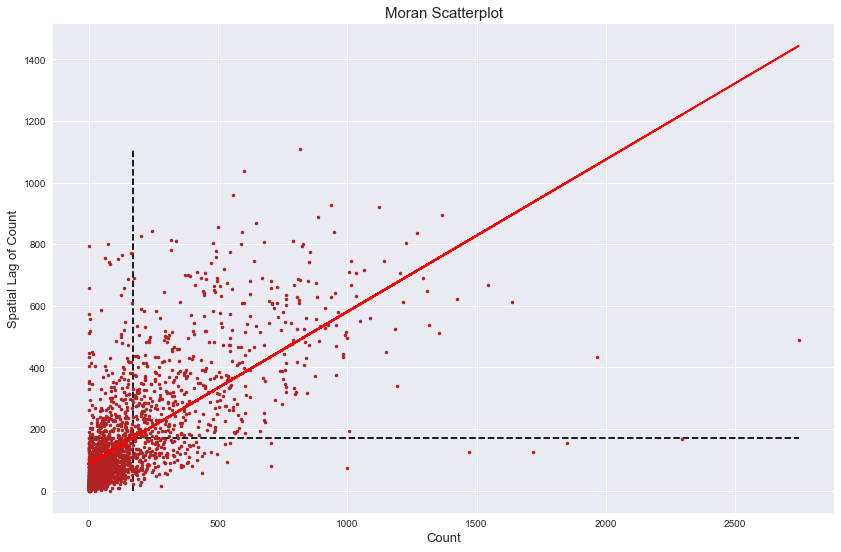

In [98]:
b, a = np.polyfit(count, countLag, 1)

f, ax = plt.subplots(1, figsize=(14, 9))

plt.plot(count, countLag, '.', color='firebrick')

 # dashed vert at mean of the last year's PCI
plt.vlines(count.mean(), countLag.min(), countLag.max(), linestyle='--')
 # dashed horizontal at mean of lagged PCI
plt.hlines(countLag.mean(), count.min(), count.max(), linestyle='--')

# red line of best fit using global I as slope
plt.plot(count, a + b*count, 'r')
plt.title('Moran Scatterplot', fontsize = 15)
plt.ylabel('Spatial Lag of Count', fontsize = 13)
plt.xlabel('Count', fontsize = 13)

In [99]:
moranI = ps.Moran(count, qW_CT)
print('Global spatial autocorrelation by Morans I is %s with p-val %s'%(moranI.I, moranI.p_sim))

Global spatial autocorrelation by Morans I is 0.494781280407 with p-val 0.001


Hence it can be observed that there is global spatial autocorrelation, identified by Moran's I of 0.4947

### Calculating local spatial autocorrelation using LISA methods

In [100]:
LMo_count = ps.Moran_Local(count, qW_CT,permutations=9999)
sigs = count[LMo_count.p_sim <= .001]
W_sigs = countLag[LMo_count.p_sim  <= .001]
insigs = count[LMo_count.p_sim > .001]
W_insigs = countLag[LMo_count.p_sim > .001]

### Plot significant LISA

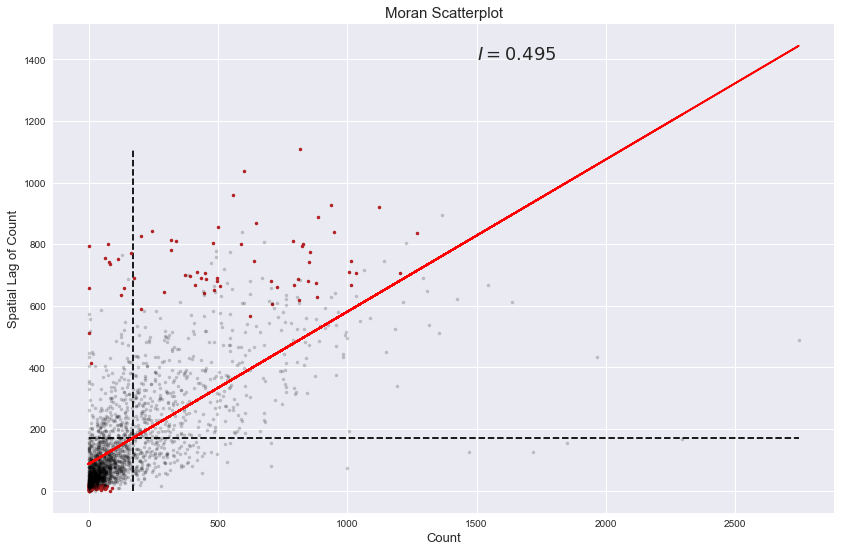

In [101]:
b, a = np.polyfit(count, countLag, 1)

f, ax = plt.subplots(1, figsize=(14, 9))

plt.plot(sigs, W_sigs, '.', color='firebrick')
plt.plot(insigs, W_insigs, '.k', alpha=.2)
plt.text(s='$I = %.3f$' % moranI.I, x=1500, y=1400, fontsize=18)

# dashed vert at mean of the last year's PCI
plt.vlines(count.mean(), countLag.min(), countLag.max(), linestyle='--')
 # dashed horizontal at mean of lagged PCI
plt.hlines(countLag.mean(), count.min(), count.max(), linestyle='--')

# red line of best fit using global I as slope
plt.plot(count, a + b*count, 'r')
plt.title('Moran Scatterplot', fontsize = 15)
plt.ylabel('Spatial Lag of Count', fontsize = 13)
plt.xlabel('Count', fontsize = 13)

### The above plot demonstates the statistically significant census tracts. The complaints are spatially autocorrelated

In [102]:
sig = LMo_count.p_sim < 0.01
hotspots = LMo_count.q==1 * sig
coldspots = LMo_count.q==3 * sig
print "Number of Hotspots:", hotspots.sum()
print "Number of Coldspots:", coldspots.sum()

Number of Hotspots: 150
Number of Coldspots: 268


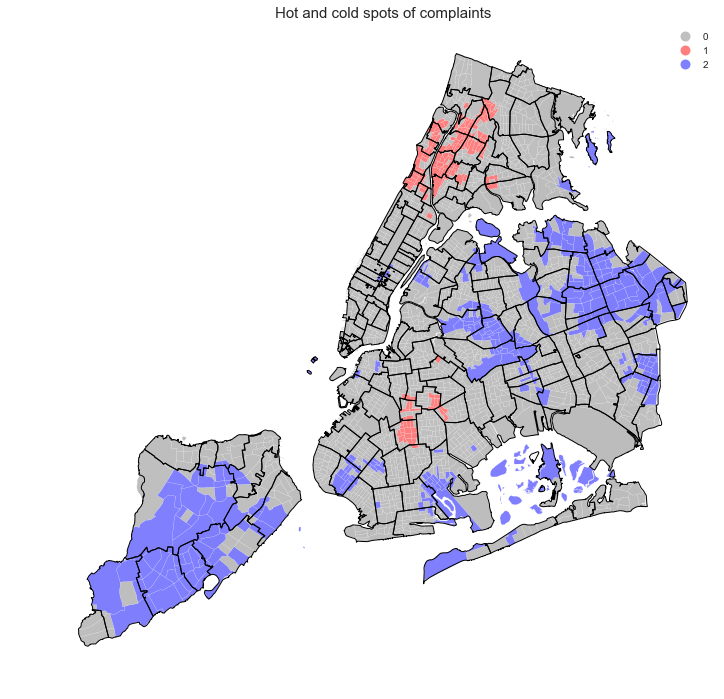

In [104]:
hcmap = colors.ListedColormap(['grey','red','blue'])
hotcold = hotspots*1 + coldspots*2

f, ax = plt.subplots(figsize=(12, 12))
spatialCount.assign(cl=hotcold).plot(column='cl', categorical=True, 
         cmap=hcmap, linewidth=0.1, ax=ax, 
         edgecolor='white', legend=True)
zipcode.plot(ax=ax, cmap=None, alpha = 0.01)

ax.set_axis_off()
plt.title("Hot and cold spots of complaints", fontsize = 15)

### The above plot is a hotspot-coldspot analysis at census tract level. I have further superimposed the zipcode shapefile to identify potential zipcodes having high complaints.

Hotspots of complaints denote contiguous regions of high complaints. It is observed in the following neighbourhoods:
* Brooklyn around the FlatBush neighbourhood
* Bronx near HighBridge and Mt Eden and 
* Upper Manhattan near Harlem and Washington Heights

In [116]:
spatialCount.loc[hotspots,'hot-cold'] = 'hot'
spatialCount.loc[coldspots, 'hot-cold'] = 'cold'
spatialCount.loc[~(hotspots | coldspots),'hot-cold'] = 'none'

### Identifying neighbourhoods using Neighborhood Tabulation Areas (NTA Name)

In [126]:
#For Manhattan
spatialCount[(spatialCount['hot-cold'] == 'hot') & (spatialCount.BoroCode == '1')]['NTAName'].value_counts()\
[spatialCount[(spatialCount['hot-cold'] == 'hot') & (spatialCount.BoroCode == '1')]['NTAName'].value_counts() >= 5]

Washington Heights South             8
Hamilton Heights                     7
Washington Heights North             7
Central Harlem North-Polo Grounds    5
Name: NTAName, dtype: int64

In [127]:
#For Bronx
spatialCount[(spatialCount['hot-cold'] == 'hot') & (spatialCount.BoroCode == '2')]['NTAName'].value_counts()\
[spatialCount[(spatialCount['hot-cold'] == 'hot') & (spatialCount.BoroCode == '2')]['NTAName'].value_counts() >= 5]

East Concourse-Concourse Village     10
Mount Hope                            9
Bedford Park-Fordham North            8
University Heights-Morris Heights     7
Highbridge                            7
West Concourse                        6
Kingsbridge Heights                   5
East Tremont                          5
Fordham South                         5
Norwood                               5
Name: NTAName, dtype: int64

In [129]:
#For Brooklyn
spatialCount[(spatialCount['hot-cold'] == 'hot') & (spatialCount.BoroCode == '3')]['NTAName'].value_counts()\
[spatialCount[(spatialCount['hot-cold'] == 'hot') & (spatialCount.BoroCode == '3')]['NTAName'].value_counts() >= 5]

Flatbush                             8
Crown Heights North                  8
Prospect Lefferts Gardens-Wingate    7
Erasmus                              6
Name: NTAName, dtype: int64

### Finding Census Tracts within Zipcode

In [158]:
CTinZipcode = gp.sjoin(zipcode, spatialCount, how='inner', op='contains')
CTinZipcode.columns

Index([       u'AREA',     u'BLDGZIP',      u'COUNTY',    u'CTY_FIPS',
        u'POPULATION',     u'PO_NAME',  u'SHAPE_AREA',   u'SHAPE_LEN',
             u'STATE',     u'ST_FIPS',         u'URL',     u'ZIPCODE',
          u'geometry', u'index_right',  u'BoroCT2010',    u'BoroCode',
          u'BoroName',  u'CDEligibil',      u'CT2010',     u'CTLabel',
            u'Count_',       u'FID_1',     u'NTACode',     u'NTAName',
          u'OBJECTID',        u'PUMA',  u'Shape_Area',  u'Shape_Le_1',
        u'Shape_Leng',    u'hot-cold'],
      dtype='object')

In [182]:
hotCountInZipcode = CTinZipcode[CTinZipcode['hot-cold'] == 'hot'].groupby('ZIPCODE').agg({'Count_': 'sum'}).reset_index()
zipcodeHot = gp.GeoDataFrame(pd.merge(zipcode, hotCountInZipcode, on='ZIPCODE', how='outer'))
zipcodeHot.replace(to_replace=np.NaN, value=0, inplace=True)
zipcodeHot.head()

,AREA,BLDGZIP,COUNTY,CTY_FIPS,POPULATION,PO_NAME,SHAPE_AREA,SHAPE_LEN,STATE,ST_FIPS,URL,ZIPCODE,geometry,Count_
0,2.269930e+07,0,Queens,081,18681.0,Jamaica,0.0,0.0,NY,36,http://www.usps.com/,11436,"POLYGON ((1038098.251871482 188138.3800067157,...",0.0
1,2.963100e+07,0,Kings,047,62426.0,Brooklyn,0.0,0.0,NY,36,http://www.usps.com/,11213,"POLYGON ((1001613.712964058 186926.4395172149,...",1739.0
2,4.197210e+07,0,Kings,047,83866.0,Brooklyn,0.0,0.0,NY,36,http://www.usps.com/,11212,"POLYGON ((1011174.275535807 183696.33770971, 1...",508.0
3,2.369863e+07,0,Kings,047,56527.0,Brooklyn,0.0,0.0,NY,36,http://www.usps.com/,11225,"POLYGON ((995908.3654508889 183617.6128015518,...",851.0
4,3.686880e+07,0,Kings,047,72280.0,Brooklyn,0.0,0.0,NY,36,http://www.usps.com/,11218,"POLYGON ((991997.1134308875 176307.4958601296,...",0.0


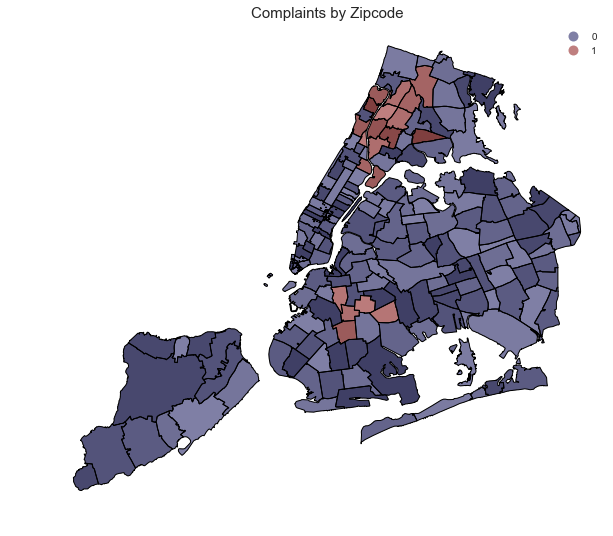

In [193]:
complaintsHot = ps.Quantiles(zipcodeHot.Count_, k=2)

f, ax = plt.subplots(figsize=(10, 9))
zipcodeHot.plot(cmap=None, linewidth = 1, ax=ax)
zipcodeHot.assign(cl=complaintsHot.yb).plot(column='cl', categorical=True, 
        k=2, cmap='seismic', linewidth=0.1, ax=ax, 
        edgecolor='black', legend=True)
ax.set_axis_off()
plt.title("Complaints by Zipcode", fontsize = 15)

### Red regions indicate hot spot zipcodes containing census tracts with high number of 311 complaints referred to the HPD

### Identifying Zipcodes with maximum hotspots

In [213]:
zipcodeHot.sort_values(by='Count_', ascending=False).set_index(['ZIPCODE',\
        'COUNTY'])[zipcodeHot.sort_values(by='Count_', ascending=False).set_index(['ZIPCODE', 'COUNTY']).Count_ > 500].Count_

ZIPCODE  COUNTY  
11226    Kings       7684.0
10453    Bronx       4032.0
10468    Bronx       3274.0
10458    Bronx       2806.0
10452    Bronx       2414.0
10456    Bronx       2217.0
10034    New York    2082.0
10457    Bronx       1876.0
11213    Kings       1739.0
10040    New York    1159.0
11225    Kings        851.0
10451    Bronx        763.0
10467    Bronx        724.0
10472    Bronx        599.0
10032    New York     538.0
11212    Kings        508.0
Name: Count_, dtype: float64

### Thus, it can be observed that there is spatial process of complaints occuring and the most complaints are occuring in ZIPCODE 11226 in Brooklyn. This analysis contains only complaints of a census tract that lie within the zipcode. It is necessary to identify all the complaints that lie within a zipcode

In [219]:
### Loading complaints by zipcode
zipcodeComplaints = gp.read_file('spatialJoinCountZipcode.shp')
zipcodeComplaints.sort_values(by='Count_', ascending=False).set_index('ZIPCODE')['Count_'][:10]

ZIPCODE
11226    15069
10453    10949
10458    10869
10467    10728
10452    10194
10468     9501
10456     9161
10457     8928
10031     7916
11225     7478
Name: Count_, dtype: int64

### Idenitifying top 10 complaints within the Zipcode

In [230]:
complaintsHighZipcode = df[df['Incident Zip'] == 11226].reset_index(drop=True)
complaintsHighZipcode.head(2)

,Unnamed: 0,Unique Key,Agency,Borough,Created Date,Closed Date,Community Board,Complaint Type,Descriptor,Latitude,Longitude,Incident Zip,Incident Address,Status,Resolution Action Updated Date,Resolution Description
0,4,36426162,HPD,BROOKLYN,06/12/2017 07:57:09 PM,06/28/2017 04:08:59 PM,09 BROOKLYN,UNSANITARY CONDITION,GARBAGE/RECYCLING STORAGE,40.655686,-73.958993,11226.0,280 PARKSIDE AVENUE,Closed,06/28/2017 04:08:59 PM,The Department of Housing Preservation and Dev...
1,17,37642230,HPD,BROOKLYN,11/08/2017 12:56:01 PM,11/10/2017 05:09:13 PM,14 BROOKLYN,DOOR/WINDOW,DOOR,40.652069,-73.963277,11226.0,68 ST PAULS PLACE,Closed,11/10/2017 05:09:13 PM,The Department of Housing Preservation and Dev...


In [242]:
complaintsHighZipcode.groupby('Complaint Type').agg({'Status' : 'count'}).sort_values(by='Status',ascending=False)[:10]

,Status
Complaint Type,
HEAT/HOT WATER,5650
UNSANITARY CONDITION,1866
PAINT/PLASTER,1631
PLUMBING,1261
WATER LEAK,938
DOOR/WINDOW,611
ELECTRIC,570
GENERAL,556
FLOORING/STAIRS,555


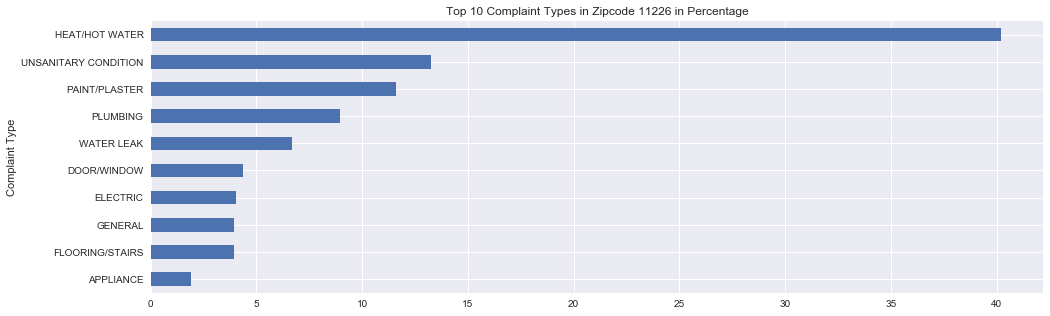

In [249]:
hpdAgg = complaintsHighZipcode.groupby('Complaint Type').agg({'Status' : 'count'})
hpdAgg['percent'] = 100.0 * hpdAgg['Status']/sum(hpdAgg.Status)
hpdAgg = hpdAgg.sort_values(by='Status')
hpdAgg.percent[-10:].plot(kind='barh', figsize = (16,5))
plt.title('Top 10 Complaint Types in Zipcode 11226 in Percentage')

### A majority of the complaints; more than 40% are for heat and hot water

### The above bar chart demonstrates the top 10 complaints in zip-code 11226 in percentage

* Heat/Hot Water
* Unsanitary Condition
* Paint/Plaster
* Plumbing
* Water Leak
* Door/Window
* Electric
* General
* Flooring/Stairs
* Appliances

In [276]:
councilDistrict = gp.read_file('nycc_17c/nycc.shp')
councilDistrict.head()

,CounDist,Shape_Area,Shape_Leng,geometry
0,43,1.468385e+08,85425.645641,"POLYGON ((975184.8121948242 173802.7479858398,..."
1,44,9.275749e+07,57615.400763,"POLYGON ((991976.8380126953 169937.2404174805,..."
2,27,2.217576e+08,82516.111914,"POLYGON ((1060282.017822266 188318.5447998047,..."
3,40,6.269852e+07,42794.272591,"POLYGON ((994667.6011962891 180893.9307861328,..."
4,41,7.815682e+07,57718.377055,"POLYGON ((1006909.950805664 189709.5687866211,..."


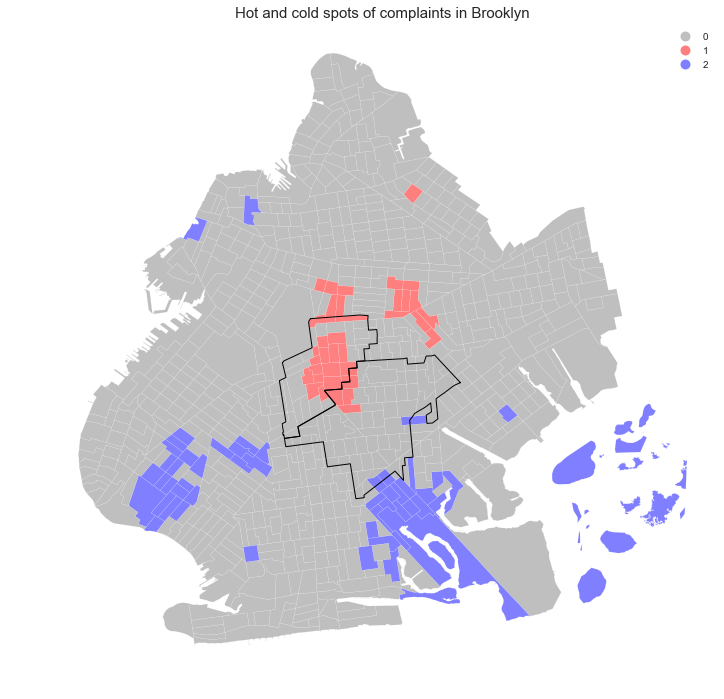

In [303]:
hcmap = colors.ListedColormap(['grey','red','blue'])
hotcold = hotspots*1 + coldspots*2

f, ax = plt.subplots(figsize=(12, 12))
spatialCount[spatialCount.BoroCode == '3'].assign(cl=hotcold[spatialCount[spatialCount.BoroCode == '3'].index]).plot(column='cl', categorical=True, 
         cmap=hcmap, linewidth=0.1, ax=ax, 
         edgecolor='white', legend=True)
councilDistrict[(councilDistrict.CounDist == 45) | (councilDistrict.CounDist == 40)].plot(ax=ax, cmap=None, alpha = 0.01)
ax.set_axis_off()
plt.title("Hot and cold spots of complaints in Brooklyn", fontsize = 15)

### Zipcode 11226 contains council districts 40 and 45. A larger volume of complaints are from council district 40 which is reprsented by council member Mathieu Eugene 